In [73]:
# Import the Earth Engine Python API
import ee
import pandas as pd
import numpy as np

# Initialize the API
ee.Initialize()

In [74]:
image = "LANDSAT/LC08/C02/T1_TOA"

# Load the LANDSAT data
collection = ee.ImageCollection(image)

# Select the band of interest
collection = collection.select(['B4', 'B5', 'QA_PIXEL']).filterDate('2015-01-01', '2023-01-01').filterBounds(area_nova)

# Define a function to extract the value and date for each image
def extract(image):
    reduced = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=area_nova, maxPixels=1e9)
    b4 = reduced.get('B4')
    b5 = reduced.get('B5')
    # qa = image.get('QA_PIXEL')
    date = image.date().format('YYYY-MM-dd')
    return ee.Feature(None, {"B4": b4, "B5": b5, 'date': date})

# Map the function over the collection and get the results
results = collection.map(extract).getInfo()

In [75]:
def extract_qa_info(value):
    if pd.isna(value):
        return value
    value = str(bin(int(value)))[2:]
    value = value.zfill(16)
    return value

def bin_condition(value, slice):
    if pd.isna(value):
        return value
    value = int(value[slice], 2)
    if value == 0:
        return np.nan
    return value

<Axes: xlabel='date'>

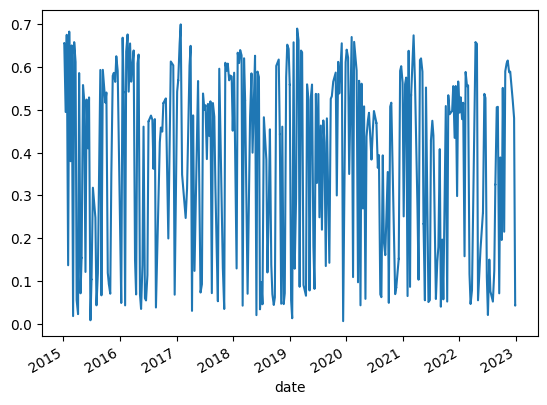

In [76]:
df = pd.DataFrame.from_records([f['properties'] for f in results['features']])
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

df["NDVI"] = (df["B5"] - df["B4"]) / (df["B5"] + df["B4"])

df["NDVI"].plot()